In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import re
import nltk

from nltk.corpus import stopwords  # Importando stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize  # Importando word_tokenize
# import ace_tools as tools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import textwrap # Ajuste de texto no print

# Baixa os stopwords em inglês (remova se já tiver baixado anteriormente)
nltk.download('stopwords')

nltk.download('wordnet')  # WordNet para lematização
nltk.download('omw-1.4')  # WordNet data for other languages

# from scipy.linalg import triu
from gensim import corpora
# from gensim.models import LdaModel  
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel 

import pyLDAvis.gensim
import pyLDAvis

from collections import Counter
import os
import sys
import warnings
import multiprocessing

multiprocessing.set_start_method("spawn", force=True)
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# os.environ["JOBLIB_MULTIPROCESSING"] = "loky"


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mborges/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mborges/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mborges/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
books_rating = pd.read_csv('../project_A3DATA/csv/Books_rating.csv')
books_rating

,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,NaN,NaN,4.0,937612800,Difficult,"This is an extremely difficult book to digest,..."
2999996,B000NSLVCU,The Idea of History,NaN,A1SMUB9ASL5L9Y,jafrank,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...
2999997,B000NSLVCU,The Idea of History,NaN,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i..."
2999998,B000NSLVCU,The Idea of History,NaN,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,..."


In [51]:
# Conforme observado, é necessário reduzir o número de amostrar no arquivo CSV para que seja capaz fazer o processamento do mesmo.
# O MOTIVO foi observado a falta de processamento pararelo, causando um consumo muito grande de memoria ram o casionando desligamento do kernel do ambiente jupyter notebook. 

In [9]:
# books_rating = books_rating[0:50000] # foi escolhido 
# books_rating


# Selecionando aleatoriamente 50.000 linhas
books_rating = books_rating.sample(n=50000, random_state=42)  # random_state para reprodutibilidade
books_rating

,Id,Title,Price,User_id,profileName,score,time,summary,text
792532,B000N7GNMO,The Complete Cartoons Of The New Yorker,NaN,A3PTG0PQY37XN4,Lui,5.0,1206230400,Amazing. Best buy ever!!!,I just bought this book(the hard cover version...
1430429,B000N6R4AA,NEW EARTH,NaN,A152DYFBLKPDT4,"jscinta ""jscinta1""",5.0,1356998400,A New Earth,Smooth transition into my Kindle...Good ValueI...
1356066,0721416594,Peter Pan Hb (Ladybird Classics),NaN,A2CNQSOKRL8GSZ,"T. Sharpton ""Homeschool Mom""",5.0,1223942400,Enchanting Story,"The story of Peter Pan is very well known, but..."
1029449,B000JBY0PG,Absolute Friends,NaN,A38Y7HWO47B7QK,"Pol Sixe ""hpolvi""",4.0,1108080000,Not so lovable losers,Is this book a satire on the whole Euro looney...
2444607,B000BL3NZ2,Of Mice & Men,NaN,NaN,NaN,4.0,940809600,What I thought about of Mice and Men,I enjoyed Of Mice and Men by John Steinbeck. T...
...,...,...,...,...,...,...,...,...,...
1335562,B000N757XK,Suburban Nation: the Rise of Sprawl and the De...,NaN,APBHXVJPCM9NT,J. Sadosky,5.0,1135900800,Great Look at the Problem of Sprawl,"Living in Northern Virginia, everyday tasks ar..."
12046,B000PDFO2Q,Small Gods,NaN,AUTBHG6070SL4,"wiredweird ""wiredweird""",5.0,1109980800,And they're all small --,-- sooner or later.Pratchett has done the unth...
2011278,038572182X,Hens Dancing: A Novel,16.95,A247379E8A29D4,A. Burton,4.0,1206835200,Really Enjoyed It!,Loved the book and fell in love with the famil...
1652644,0385334338,Darkest Fear : A Myron Bolitar Novel,NaN,AFVQZQ8PW0L,Harriet Klausner,5.0,961200000,Pure Ambrosia,When sports representative Myron Bolitar visit...


# Analise exploratorio para books_rating
Limpeza do dataframe booke_rating

In [11]:
books_rating.dtypes

Id              object
Title           object
Price          float64
User_id         object
profileName     object
score          float64
time             int64
summary         object
text            object
dtype: object

In [13]:
books_rating.isna().sum() # resultdo da contagem de NaN em cada coluna

Id                 0
Title              4
Price          42062
User_id         9187
profileName     9188
score              0
time               0
summary            9
text               0
dtype: int64

In [15]:
""" para o preenchimento da colunas onde há valores valores ausentes, foi escolhido mudar por desconcido e 
    a coluna Price pegar a media de preços dos livros para ser colocado no lugar de NaN
"""

# utilizando o método assing para evistar copias redundantes no dataframe e excevio consumo de mémoria
books_rating = books_rating.assign(
    Price=books_rating['Price'].fillna(books_rating['Price'].mean()),
    User_id=books_rating['User_id'].fillna('UNKNOWN'),
    Title=books_rating['Title'].fillna('UNKNOWN'),
    profileName=books_rating['profileName'].fillna('UNKNOWN'),
    summary=books_rating['summary'].fillna('UNKNOWN'),
    text=books_rating['text'].fillna('UNKNOWN')
)
books_rating.isna().sum() # resultdo da contagem de NaN em cada coluna

Id             0
Title          0
Price          0
User_id        0
profileName    0
score          0
time           0
summary        0
text           0
dtype: int64

In [17]:
books_rating.head(4)

,Id,Title,Price,User_id,profileName,score,time,summary,text
792532,B000N7GNMO,The Complete Cartoons Of The New Yorker,21.886407,A3PTG0PQY37XN4,Lui,5.0,1206230400,Amazing. Best buy ever!!!,I just bought this book(the hard cover version...
1430429,B000N6R4AA,NEW EARTH,21.886407,A152DYFBLKPDT4,"jscinta ""jscinta1""",5.0,1356998400,A New Earth,Smooth transition into my Kindle...Good ValueI...
1356066,0721416594,Peter Pan Hb (Ladybird Classics),21.886407,A2CNQSOKRL8GSZ,"T. Sharpton ""Homeschool Mom""",5.0,1223942400,Enchanting Story,"The story of Peter Pan is very well known, but..."
1029449,B000JBY0PG,Absolute Friends,21.886407,A38Y7HWO47B7QK,"Pol Sixe ""hpolvi""",4.0,1108080000,Not so lovable losers,Is this book a satire on the whole Euro looney...


In [19]:
# Analise exploratoria mais detalhadas
# Converter a coluna 'time' do formato Unix
books_rating['time'] = pd.to_datetime(books_rating['time'], unit='s')
books_rating['time']

792532    2008-03-23
1430429   2013-01-01
1356066   2008-10-14
1029449   2005-02-11
2444607   1999-10-25
             ...    
1335562   2005-12-30
12046     2005-03-05
2011278   2008-03-30
1652644   2000-06-17
634228    2010-11-22
Name: time, Length: 50000, dtype: datetime64[ns]

In [21]:
# Selecione apenas as colunas numéricas para análise exploratória
books_rating.select_dtypes(include=['float64', 'int64']).describe()

,Price,score
count,50000.000000,50000.000000
mean,21.886407,4.216780
std,11.223910,1.203102
min,1.000000,1.000000
25%,21.886407,4.000000
50%,21.886407,5.000000
75%,21.886407,5.000000
max,665.560000,5.000000


In [23]:
books_rating.to_csv('../project_A3DATA/csv/books_rating_50k.csv', index=False)

In [25]:
# Verificar as datas mais recentes na coluna
print("\nVerificar as datas mais recentes na coluna")
books_rating['time'].sort_values(ascending=False).head(10)


Verificar as datas mais recentes na coluna


941561    2013-03-03
2618637   2013-03-03
455355    2013-03-03
2655525   2013-03-03
1411427   2013-03-03
1485515   2013-03-03
1320251   2013-03-03
1053966   2013-03-03
1149202   2013-03-03
585463    2013-03-03
Name: time, dtype: datetime64[ns]

In [27]:
# Verificar as maiores pontuações de avaliação (score) no dataset
print("\nVerificar as maiores pontuações de avaliação (score) no dataset")

books_rating[['score', 'Title', 'time']].sort_values(by='time', ascending=False).head(10)


Verificar as maiores pontuações de avaliação (score) no dataset


,score,Title,time
941561,5.0,Wuthering Heights (Riverside editions),2013-03-03
2618637,4.0,The DIFFERENT DRUM CASSETTE,2013-03-03
455355,5.0,Again,2013-03-03
2655525,5.0,Empty Land,2013-03-03
1411427,5.0,Magician,2013-03-03
1485515,5.0,Honor Bound,2013-03-03
1320251,5.0,Wuthering Heights (Penguin Audiobooks),2013-03-03
1053966,5.0,"The Root of Chinese Qigong: Secrets of Health,...",2013-03-03
1149202,5.0,What Is Meditation?: Buddhism for Everyone,2013-03-03
585463,5.0,Jane Eyre: Complete and Unabridged (Puffin Cla...,2013-03-03



Plotando a distribuição das pontuações (score)



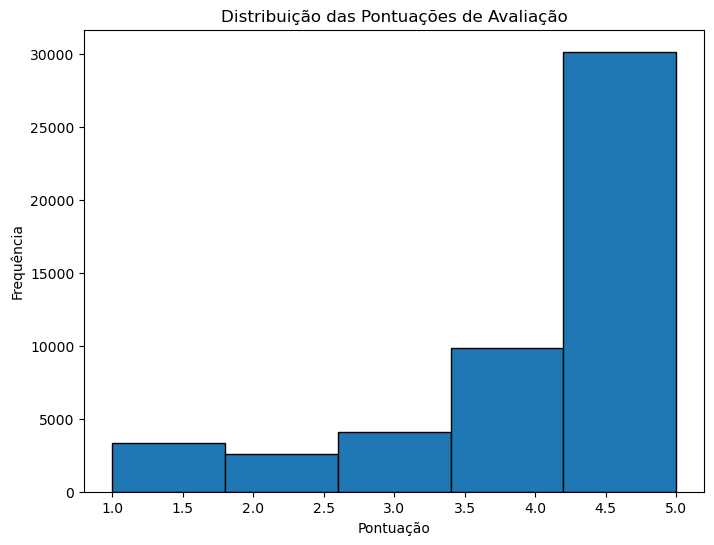

In [29]:
# Plotando a distribuição das pontuações (score)
print("\nPlotando a distribuição das pontuações (score)\n")

plt.figure(figsize=(8, 6))
plt.hist(books_rating['score'], bins=5, edgecolor='black')
plt.title('Distribuição das Pontuações de Avaliação')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.show();

In [31]:
# Exibir os títulos com mais avaliações
# Contar a quantidade de avaliações por título e ordenar para encontrar os mais avaliados

top_reviewed_titles = books_rating['Title'].value_counts().head(10) # escolhido 10  titulos
top_reviewed_titles_df = top_reviewed_titles.reset_index()
top_reviewed_titles_df.columns = ['Title', 'Review_Count']

print("\nTítulos com mais avaliações")
top_reviewed_titles_df


Títulos com mais avaliações


,Title,Review_Count
0,Pride and Prejudice,345
1,The Hobbit,334
2,Atlas Shrugged,217
3,Wuthering Heights,201
4,The Giver,134
5,Of Mice and Men,120
6,Harry Potter and The Sorcerer's Stone,116
7,The Picture of Dorian Gray,115
8,Great Expectations,114
9,Mere Christianity,104


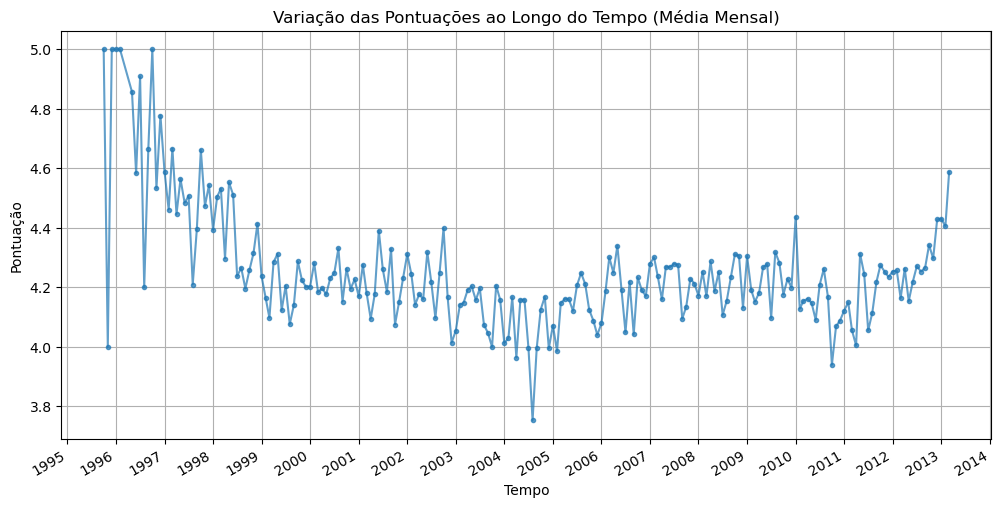

In [33]:
# Ordenar os dados por data para uma análise temporal
data_sorted = books_rating.sort_values(by='time')

# Reduzir a granularidade das datas para a média anual das pontuações
data_grouped = data_sorted.groupby(data_sorted['time'].dt.to_period('M')).agg({'score': 'mean'}).reset_index()
data_grouped['time'] = data_grouped['time'].dt.to_timestamp()  # Converter Period para Timestamp

# Plotando a variação das pontuações ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(data_grouped['time'], data_grouped['score'], marker='o', linestyle='-', markersize=3, alpha=0.7)

plt.title('Variação das Pontuações ao Longo do Tempo (Média Mensal)')
plt.xlabel('Tempo')
plt.ylabel('Pontuação')
plt.grid(True)

# Formatando eixos para melhor visualização
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotacionar datas para melhor leitura

plt.show()


/tmp/ipykernel_3973/1233687742.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_sorted['time'].dt.year, y=data_sorted['score'], palette="Set3")


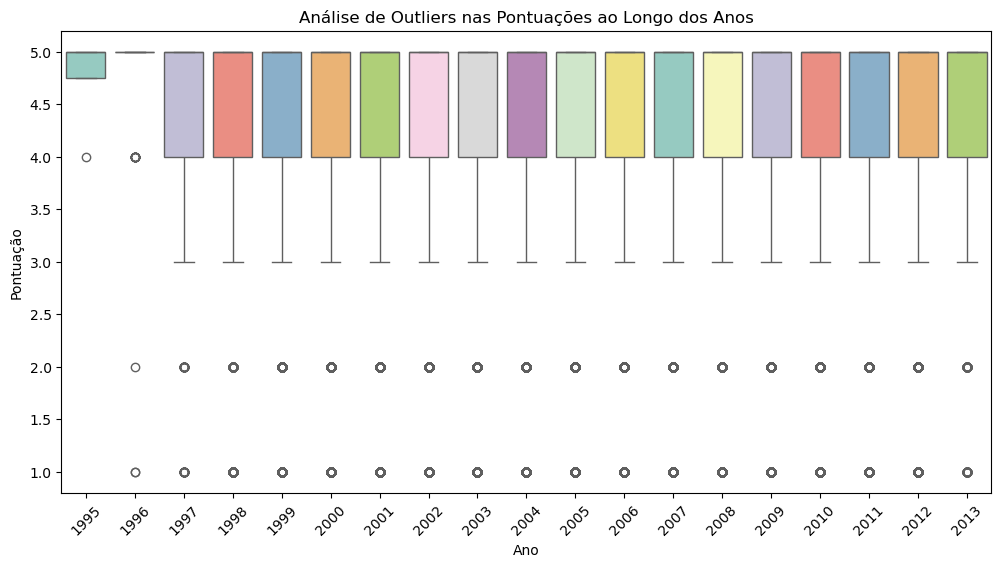

In [35]:
# Analisar outliers nas pontuações ao longo do tempo

# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar um boxplot para visualizar outliers nas pontuações ao longo do tempo
sns.boxplot(x=data_sorted['time'].dt.year, y=data_sorted['score'], palette="Set3")
plt.title('Análise de Outliers nas Pontuações ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Pontuação')
plt.xticks(rotation=45)

plt.show();

### O boxplot acima mostra a análise de outliers nas pontuações ao longo dos anos. Ele ajuda a identificar anos com avaliações que se destacam (acima ou abaixo do padrão), indicando períodos de maior variação nas opiniões d os leitores.

In [37]:
# Quais anos tiveram mais avaliações baixas?

# Filtrar as avaliações baixas (definidas como pontuações menores ou iguais a 2) e contar por ano
low_scores = books_rating[books_rating['score'] <= 2]
low_scores_per_year = low_scores['time'].dt.year.value_counts().sort_index()

# Exibir os anos com maior quantidade de avaliações baixas
low_scores_per_year_df = low_scores_per_year.reset_index()
low_scores_per_year_df.columns = ['Year', 'Low_Score_Count']

low_scores_per_year_df.head(5)

,Year,Low_Score_Count
0,1996,3
1,1997,59
2,1998,219
3,1999,510
4,2000,420


In [39]:
# Remove caracteres especiais, pontuação e números, e converte para letras minúsculas da coluna 'summary'

books_rating['cleaned_summary'] = books_rating['summary'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower()) 

# Remove caracteres especiais, pontuação e números, e converte para letras minúsculas na coluna 'text'
books_rating['cleaned_text'] = books_rating['text'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

# Exibe as colunas originais e as colunas limpas para verificação
books_rating[['summary', 'cleaned_summary', 'text', 'cleaned_text']].head(8)


,summary,cleaned_summary,text,cleaned_text
792532,Amazing. Best buy ever!!!,amazing best buy ever,I just bought this book(the hard cover version...,i just bought this bookthe hard cover version ...
1430429,A New Earth,a new earth,Smooth transition into my Kindle...Good ValueI...,smooth transition into my kindlegood valuei wo...
1356066,Enchanting Story,enchanting story,"The story of Peter Pan is very well known, but...",the story of peter pan is very well known but ...
1029449,Not so lovable losers,not so lovable losers,Is this book a satire on the whole Euro looney...,is this book a satire on the whole euro looney...
2444607,What I thought about of Mice and Men,what i thought about of mice and men,I enjoyed Of Mice and Men by John Steinbeck. T...,i enjoyed of mice and men by john steinbeck th...
2960870,Mr. Bolan is Angry...,mr bolan is angry,Season of Slaughter may not be considered a ho...,season of slaughter may not be considered a ho...
1436787,Please stop laughing at me,please stop laughing at me,Bullying is not a new phenomenon. But that doe...,bullying is not a new phenomenon but that does...
928402,Thank heaven for frugal grandmothers,thank heaven for frugal grandmothers,My grandmother threw no children's books out e...,my grandmother threw no childrens books out ev...


In [41]:
# Define os stopwords em inglês
stop_words = set(stopwords.words('english'))

# Remove stopwords da coluna 'cleaned_summary'
books_rating['cleaned_summary_no_stopwords'] = books_rating['cleaned_summary'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)

# Remove stopwords da coluna 'cleaned_text'
books_rating['cleaned_text_no_stopwords'] = books_rating['cleaned_text'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)

# Exibir as colunas com stopwords e  sem stopwords para verificação
books_rating[['cleaned_summary', 'cleaned_summary_no_stopwords', 'cleaned_text', 'cleaned_text_no_stopwords']].head()

,cleaned_summary,cleaned_summary_no_stopwords,cleaned_text,cleaned_text_no_stopwords
792532,amazing best buy ever,amazing best buy ever,i just bought this bookthe hard cover version ...,bought bookthe hard cover version think brilli...
1430429,a new earth,new earth,smooth transition into my kindlegood valuei wo...,smooth transition kindlegood valuei would purc...
1356066,enchanting story,enchanting story,the story of peter pan is very well known but ...,story peter pan well known wonder many people ...
1029449,not so lovable losers,lovable losers,is this book a satire on the whole euro looney...,book satire whole euro looney left seems like ...
2444607,what i thought about of mice and men,thought mice men,i enjoyed of mice and men by john steinbeck th...,enjoyed mice men john steinbeck book great cau...


In [43]:
# Realizando a tokenização nas colunas de texto limpo e sem stopwords
books_rating['tokenized_summary'] = books_rating['cleaned_summary_no_stopwords'].apply(lambda x: x.split())
books_rating['tokenized_text']    = books_rating['cleaned_text_no_stopwords'].apply(lambda x: x.split())

# Exibindo as colunas com tokens e já tokenizadas para verificação
books_rating[['cleaned_summary_no_stopwords', 'tokenized_summary', 'cleaned_text_no_stopwords', 'tokenized_text']].head(6)

,cleaned_summary_no_stopwords,tokenized_summary,cleaned_text_no_stopwords,tokenized_text
792532,amazing best buy ever,"[amazing, best, buy, ever]",bought bookthe hard cover version think brilli...,"[bought, bookthe, hard, cover, version, think,..."
1430429,new earth,"[new, earth]",smooth transition kindlegood valuei would purc...,"[smooth, transition, kindlegood, valuei, would..."
1356066,enchanting story,"[enchanting, story]",story peter pan well known wonder many people ...,"[story, peter, pan, well, known, wonder, many,..."
1029449,lovable losers,"[lovable, losers]",book satire whole euro looney left seems like ...,"[book, satire, whole, euro, looney, left, seem..."
2444607,thought mice men,"[thought, mice, men]",enjoyed mice men john steinbeck book great cau...,"[enjoyed, mice, men, john, steinbeck, book, gr..."
2960870,mr bolan angry,"[mr, bolan, angry]",season slaughter may considered horror novel m...,"[season, slaughter, may, considered, horror, n..."


In [45]:
# Inicializando o Stemmer e o Lemmatizer para inglês
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Aplicando lematização e stemming nos tokens de 'tokenized_summary' e 'tokenized_text'
books_rating['stemmed_summary'] = books_rating['tokenized_summary'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
books_rating['stemmed_text']    = books_rating['tokenized_text'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

# Exibindo as colunas com tokens lematizados e reduzidos
books_rating[['tokenized_summary', 'stemmed_summary', 'tokenized_text', 'stemmed_text']].head()

,tokenized_summary,stemmed_summary,tokenized_text,stemmed_text
792532,"[amazing, best, buy, ever]","[amaz, best, buy, ever]","[bought, bookthe, hard, cover, version, think,...","[bought, bookth, hard, cover, version, think, ..."
1430429,"[new, earth]","[new, earth]","[smooth, transition, kindlegood, valuei, would...","[smooth, transit, kindlegood, valuei, would, p..."
1356066,"[enchanting, story]","[enchant, stori]","[story, peter, pan, well, known, wonder, many,...","[stori, peter, pan, well, known, wonder, mani,..."
1029449,"[lovable, losers]","[lovabl, loser]","[book, satire, whole, euro, looney, left, seem...","[book, satir, whole, euro, looney, left, seem,..."
2444607,"[thought, mice, men]","[thought, mice, men]","[enjoyed, mice, men, john, steinbeck, book, gr...","[enjoy, mice, men, john, steinbeck, book, grea..."


In [47]:
# Juntando todos os tokens da coluna 'stemmed_text' para análise de frequência
all_stemmed_words = [word for tokens in books_rating['stemmed_text'] for word in tokens]

# Contando a frequência de cada palavra
word_frequency = Counter(all_stemmed_words)

# Convertendo para DataFrame para visualização
word_frequency_df = pd.DataFrame(word_frequency.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Exibindo o DataFrame de frequência de palavras ao usuário

print("\nAnalisar frequência de palavras no texto\n")
word_frequency_df


Analisar frequência de palavras no texto



,word,frequency
7,book,105272
18,read,50797
89,one,31155
57,stori,24518
13,like,22246
...,...,...
71199,quotprogressivequotbook,1
71198,everespeci,1
71197,betterthen,1
71196,thesist,1


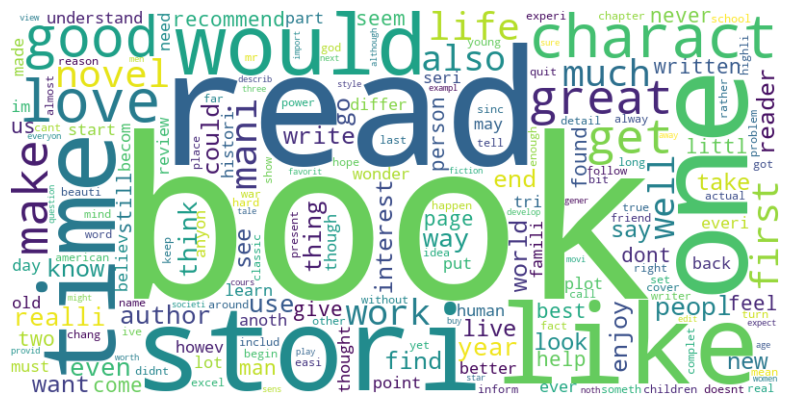

In [49]:
# Gerando a nuvem de palavras com base nas frequências
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)

# Exibindo a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

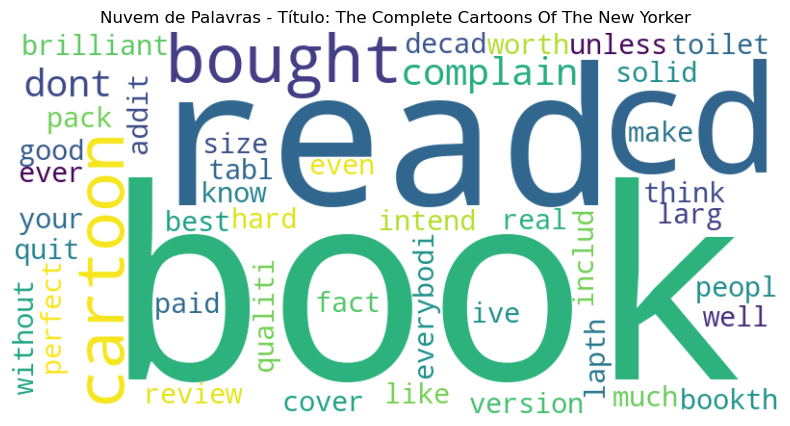

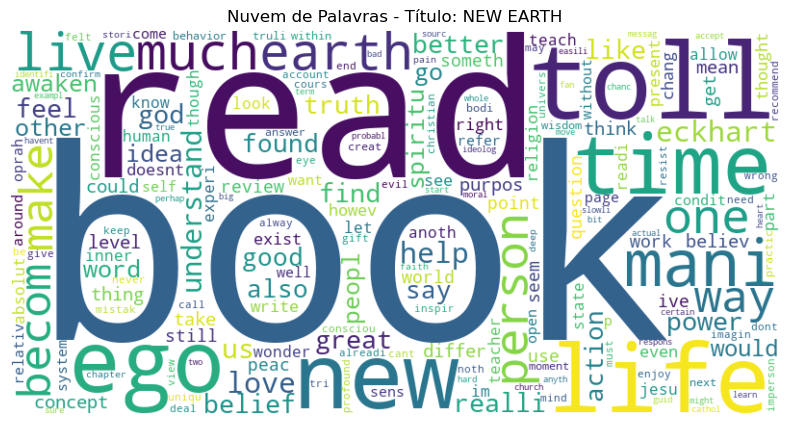

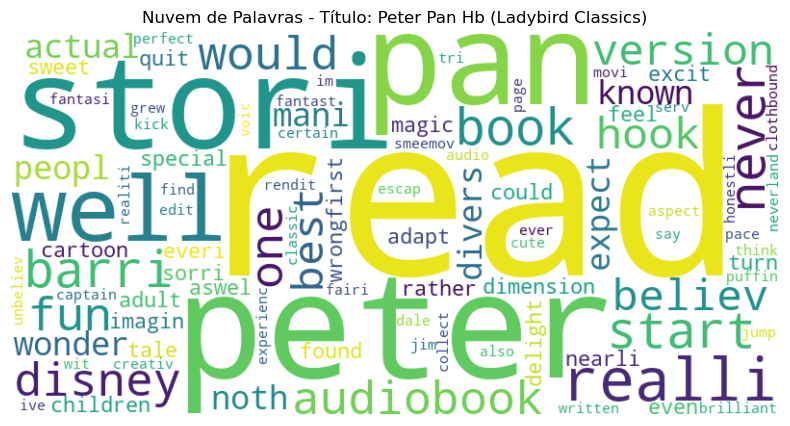

In [51]:
# Criando uma nuvem de palavras por título de livro
# Vamos agrupar os dados por título e gerar uma nuvem para cada um

# Selecionando um título de exemplo para visualização (se houver muitos títulos)
example_titles = books_rating['Title'].unique()[:3]  # Selecionando apenas 3 títulos para exemplo

# Gerando e exibindo a nuvem de palavras para cada título selecionado
for title in example_titles:
    # Filtrando as palavras do texto stemmed para o título específico
    words = [word for tokens in books_rating[books_rating['Title'] == title]['stemmed_text'] for word in tokens]
    word_freq = Counter(words)
    
    # Gerando a nuvem de palavras para o título
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Exibindo a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuvem de Palavras - Título: {title}")
    plt.show()


In [53]:
"""
Para realizar uma análise de sentimento nos resumos ou descrições dos livros, é utlizado a  biblioteca TextBlob.
A TextBlob calcula o sentimento de cada texto, retornando uma polaridade que varia de -1 (muito negativo) a +1 (muito positivo)
"""

# Aplicando a análise de sentimento diretamente nos resumos limpos e sem stopwords
books_rating['summary_sentiment'] = books_rating['cleaned_summary_no_stopwords'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Exibindo o DataFrame com o sentimento dos resumos
print('\nExibindo o DataFrame com o sentimento dos resumos\n')
books_rating[['Title', 'cleaned_summary_no_stopwords', 'summary_sentiment']].head(6)


Exibindo o DataFrame com o sentimento dos resumos



,Title,cleaned_summary_no_stopwords,summary_sentiment
792532,The Complete Cartoons Of The New Yorker,amazing best buy ever,0.800000
1430429,NEW EARTH,new earth,0.136364
1356066,Peter Pan Hb (Ladybird Classics),enchanting story,0.000000
1029449,Absolute Friends,lovable losers,0.150000
2444607,Of Mice & Men,thought mice men,0.000000
2960870,Season of Slaughter (Superbolan),mr bolan angry,-0.500000


In [57]:
# Filtrando os resumos que possuem sentimento negativo
negative_summaries_df = books_rating[books_rating['summary_sentiment'] < 0][['Title', 'cleaned_summary_no_stopwords', 'summary_sentiment']]
print("\nResumos com Sentimento Negativo\n")

negative_summaries_df.head(4)


Resumos com Sentimento Negativo



,Title,cleaned_summary_no_stopwords,summary_sentiment
2960870,Season of Slaughter (Superbolan),mr bolan angry,-0.500000
851058,Of Mice And Men,sad enjoyable hard put,-0.097222
1330130,Exit Betty,little white heap altar,-0.093750
226785,How Israel Lost : The Four Questions,extremely helpful book,-0.125000


In [59]:
# Agrupe sentimentos por pontuação de livros

# Agrupando a média dos sentimentos por pontuação dos livros
sentiment_by_score_df = books_rating.groupby('score')['summary_sentiment'].mean().reset_index()

print("\nGrupo de sentimentos por pontuação de livros\n")
sentiment_by_score_df


Grupo de sentimentos por pontuação de livros



,score,summary_sentiment
0,1.0,-0.124565
1,2.0,-0.006536
2,3.0,0.142507
3,4.0,0.249742
4,5.0,0.313420


In [61]:
# Criando um dicionário e uma matriz de frequência para a coluna 'stemmed_text'

dictionary = corpora.Dictionary(books_rating['stemmed_text'])
corpus = [dictionary.doc2bow(text) for text in books_rating['stemmed_text']]

# Treinando o modelo LDA com LdaMulticore usando 20 tópicos para mais precisão
lda_model = LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=10, random_state=42, workers=4)

# Exibindo os principais tópicos identificados
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic,"\n")

# Avaliando a coerência dos tópicos
coherence_model = CoherenceModel(model=lda_model, texts=books_rating['stemmed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"\nCoerência dos Tópicos: {coherence_score}\n\n")

(0, '0.037*"book" + 0.012*"use" + 0.006*"one" + 0.006*"inform" + 0.005*"make"') 

(1, '0.009*"book" + 0.008*"god" + 0.007*"one" + 0.007*"christian" + 0.005*"word"') 

(2, '0.089*"book" + 0.031*"read" + 0.012*"great" + 0.012*"recommend" + 0.010*"life"') 

(3, '0.052*"book" + 0.036*"read" + 0.014*"stori" + 0.013*"one" + 0.012*"like"') 

(4, '0.011*"stori" + 0.007*"book" + 0.007*"famili" + 0.007*"one" + 0.006*"live"') 

(5, '0.028*"book" + 0.012*"money" + 0.008*"condit" + 0.007*"great" + 0.007*"order"') 

(6, '0.032*"austen" + 0.017*"emma" + 0.015*"jane" + 0.015*"shakespear" + 0.014*"christi"') 

(7, '0.011*"novel" + 0.007*"one" + 0.007*"charact" + 0.006*"war" + 0.006*"stori"') 

(8, '0.021*"book" + 0.009*"ring" + 0.007*"lord" + 0.007*"tolkien" + 0.007*"one"') 

(9, '0.010*"book" + 0.007*"world" + 0.007*"human" + 0.006*"one" + 0.005*"peopl"') 


Coerência dos Tópicos: 0.34550742181209465




In [63]:
# Visualização com pyLDAvis
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3973) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3973) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3973) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=3973) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/mborges/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/b

## <br/><br/>Os principais tópicos identificados pelo modelo LDA para os livros incluem conjuntos de palavras frequentemente associadas, indicando possíveis temas. Abaixo é indentificado cinco tópicos principais:

In [67]:
# Extraindo os tópicos para cada documento (livro) no corpus
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

# Criando uma lista com o tópico mais relevante (de maior peso) para cada livro
book_topics = []
for doc_topic in doc_topics:
    # Ordena os tópicos do documento pela relevância e pega o tópico mais relevante
    dominant_topic = sorted(doc_topic, key=lambda x: -x[1])[0][0]
    book_topics.append(dominant_topic)

# Adicionando os tópicos dominantes aos dados
books_rating['Dominant_Topic'] = book_topics

# Exibindo os títulos e seus tópicos dominantes
books_rating[['Title', 'Dominant_Topic']].head(8)


,Title,Dominant_Topic
792532,The Complete Cartoons Of The New Yorker,0
1430429,NEW EARTH,8
1356066,Peter Pan Hb (Ladybird Classics),3
1029449,Absolute Friends,3
2444607,Of Mice & Men,2
2960870,Season of Slaughter (Superbolan),3
1436787,Please Stop Laughing At Me...: One Woman's Ins...,3
928402,"The Birds' Christmas Carol,",3


<Figure size 1400x1000 with 0 Axes>

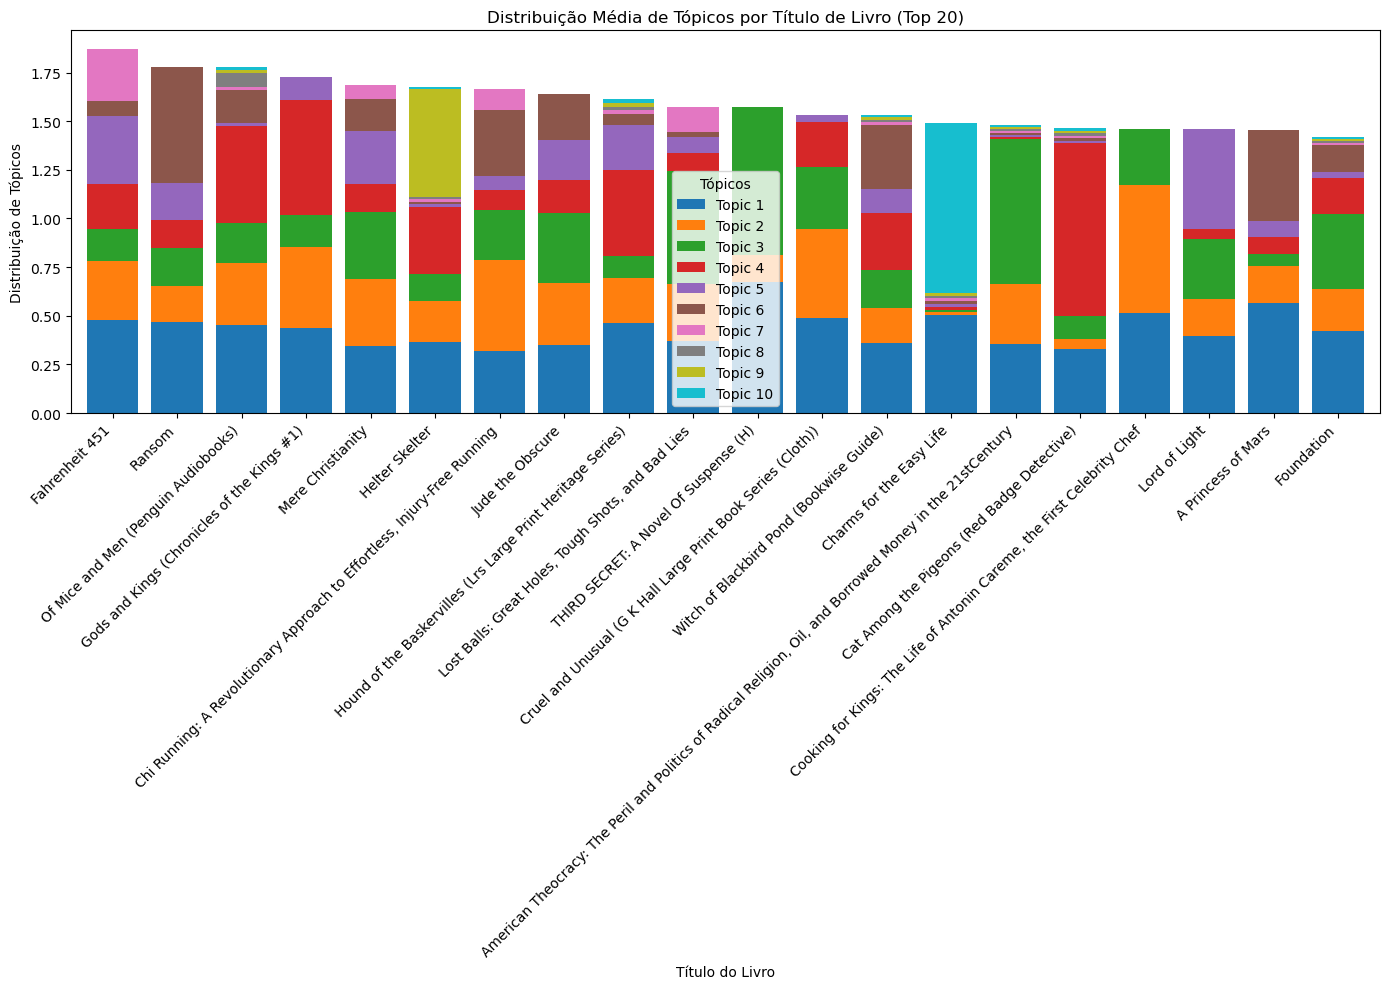

In [69]:
# Obter a distribuição de tópicos para cada documento no corpus
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Converter as distribuições de tópicos em um DataFrame para facilitar a visualização
topic_dist_df = pd.DataFrame([[topic[1] for topic in doc] for doc in topic_distributions])
topic_dist_df.columns = [f'Topic {i+1}' for i in range(topic_dist_df.shape[1])]
topic_dist_df['Title'] = books_rating['Title']

# Calculando a média dos tópicos por livro
average_topic_dist = topic_dist_df.groupby('Title').mean()

# Selecionando os 20 títulos com maior distribuição de tópicos para visualização
top_titles = average_topic_dist.sum(axis=1).nlargest(20).index
average_topic_dist_top = average_topic_dist.loc[top_titles]

# Visualizando a distribuição média dos tópicos por título de livro
plt.figure(figsize=(14, 10))
average_topic_dist_top.plot(kind='bar', stacked=True, figsize=(14, 10), width=0.8)
plt.title("Distribuição Média de Tópicos por Título de Livro (Top 20)")
plt.xlabel("Título do Livro")
plt.ylabel("Distribuição de Tópicos")
plt.legend(title="Tópicos")
plt.xticks(rotation=45, ha="right")  
plt.tight_layout()
plt.show();


In [71]:
texto = """Aqui estão os primeiros resultados dos livros agrupados por similaridade, com cada título associado a um cluster específico (de 0 a 4). 
        Esse agrupamento indica quais livros possuem conteúdo semelhante, conforme analisado pelo modelo K-Means usando TF-IDF."""

texto_ajustado = textwrap.fill(texto, width=60)


# Convertendo a coluna 'stemmed_text' para uma lista de strings, unindo tokens com espaço
documents = [" ".join(text) if isinstance(text, list) else text for text in books_rating['stemmed_text']]

# Aplicando o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Definindo o número de clusters e aplicando o KMeans
num_clusters = 5  # Podemos ajustar este número conforme necessário

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
books_rating['Cluster'] = kmeans.fit_predict(tfidf_matrix)

# Exibindo os títulos dos livros com os clusters atribuídos
df_clustered = books_rating[['Title', 'Cluster', 'text']]

print(texto_ajustado,"\n")
df_clustered.head(6)

Aqui estão os primeiros resultados dos livros agrupados por
similaridade, com cada título associado a um cluster
específico (de 0 a 4).          Esse agrupamento indica
quais livros possuem conteúdo semelhante, conforme analisado
pelo modelo K-Means usando TF-IDF. 



,Title,Cluster,text
792532,The Complete Cartoons Of The New Yorker,0,I just bought this book(the hard cover version...
1430429,NEW EARTH,1,Smooth transition into my Kindle...Good ValueI...
1356066,Peter Pan Hb (Ladybird Classics),4,"The story of Peter Pan is very well known, but..."
1029449,Absolute Friends,1,Is this book a satire on the whole Euro looney...
2444607,Of Mice & Men,2,I enjoyed Of Mice and Men by John Steinbeck. T...
2960870,Season of Slaughter (Superbolan),3,Season of Slaughter may not be considered a ho...


In [73]:
# Obtenção dos termos principais para cada cluster com base nos centróides do K-Means

# Cada linha em cluster_centers_ é um centróide de cluster com os pesos dos termos
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Ordena os índices dos termos por peso

# Coletando os principais termos para cada cluster
top_terms_per_cluster = {}
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Pega os 10 termos mais representativos
    top_terms_per_cluster[f'Cluster {i}'] = top_terms

# Convertendo para DataFrame para melhor visualização
top_terms_df = pd.DataFrame.from_dict(top_terms_per_cluster, orient='index', columns=[f'Term {i+1}' for i in range(10)])

# Exibindo a tabela com os termos principais de cada cluster
top_terms_df


,Term 1,Term 2,Term 3,Term 4,Term 5,Term 6,Term 7,Term 8,Term 9,Term 10
Cluster 0,read,book,love,one,like,time,enjoy,good,great,first
Cluster 1,book,read,one,work,life,time,mani,us,histori,author
Cluster 2,book,great,use,good,inform,help,recommend,would,like,get
Cluster 3,novel,charact,book,one,read,like,stori,time,life,love
Cluster 4,stori,book,read,love,one,charact,great,like,good,time


In [79]:
# Preparando os documentos para o modelo Doc2Vec
documents = [TaggedDocument(words=" ".join(text).split(), tags=[str(i)]) for i, text in enumerate(books_rating['stemmed_text'])]

# Treinando o modelo Doc2Vec para criar embeddings de cada livro
doc2vec_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, epochs=40, seed=42)

# Extraindo os vetores para cada livro
book_embeddings = np.array([doc2vec_model.dv[str(i)] for i in range(len(books_rating))])

# Calculando a similaridade de cosseno entre os livros
similarity_matrix = cosine_similarity(book_embeddings)

# Transformando a matriz de similaridade em um DataFrame para facilitar a análise
similarity_df = pd.DataFrame(similarity_matrix, index=books_rating['Title'], columns=books_rating['Title'])

# Exibindo uma amostra da matriz de similaridade
similarity_df.iloc[:10, :10]  # Exibindo apenas uma parte para evitar excesso de dados


Title,The Complete Cartoons Of The New Yorker,NEW EARTH,Peter Pan Hb (Ladybird Classics),Absolute Friends,Of Mice & Men,Season of Slaughter (Superbolan),Please Stop Laughing At Me...: One Woman's Inspirational Story,"The Birds' Christmas Carol,",The Lord's oysters,"Finding Meaning in the Second Half of Life: How to Finally, Really Grow Up"
Title,,,,,,,,,,
The Complete Cartoons Of The New Yorker,1.000000,0.316621,0.419149,0.171828,0.250925,0.073912,0.103912,0.325578,0.093439,-0.041338
NEW EARTH,0.316621,1.000000,0.162290,0.120793,0.298030,0.115771,0.126349,0.036261,0.322855,0.227732
Peter Pan Hb (Ladybird Classics),0.419149,0.162290,1.000000,0.157493,0.183374,0.043995,0.044775,0.278751,0.086501,0.104079
Absolute Friends,0.171828,0.120793,0.157493,1.000000,0.194253,0.265029,0.155489,-0.006634,0.043317,-0.139848
Of Mice & Men,0.250925,0.298030,0.183374,0.194253,1.000000,0.317240,0.089807,0.151618,0.122660,0.103736
Season of Slaughter (Superbolan),0.073912,0.115771,0.043995,0.265029,0.317240,1.000000,0.248212,-0.036235,-0.116219,-0.150915
Please Stop Laughing At Me...: One Woman's Inspirational Story,0.103912,0.126349,0.044775,0.155489,0.089807,0.248212,1.000000,0.257874,0.102931,0.142807
"The Birds' Christmas Carol,",0.325578,0.036261,0.278751,-0.006634,0.151618,-0.036235,0.257874,1.000000,0.430828,0.008576
The Lord's oysters,0.093439,0.322855,0.086501,0.043317,0.122660,-0.116219,0.102931,0.430828,1.000000,0.133627


/tmp/ipykernel_3973/3695426121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


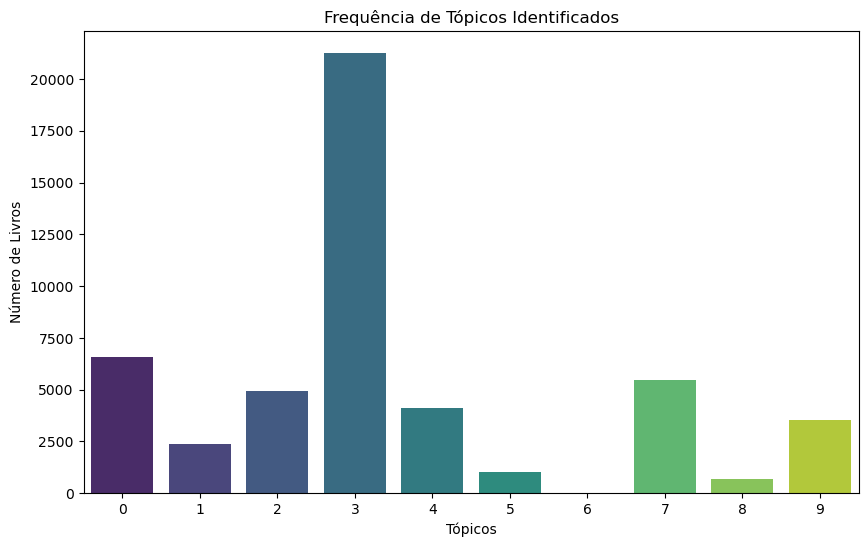

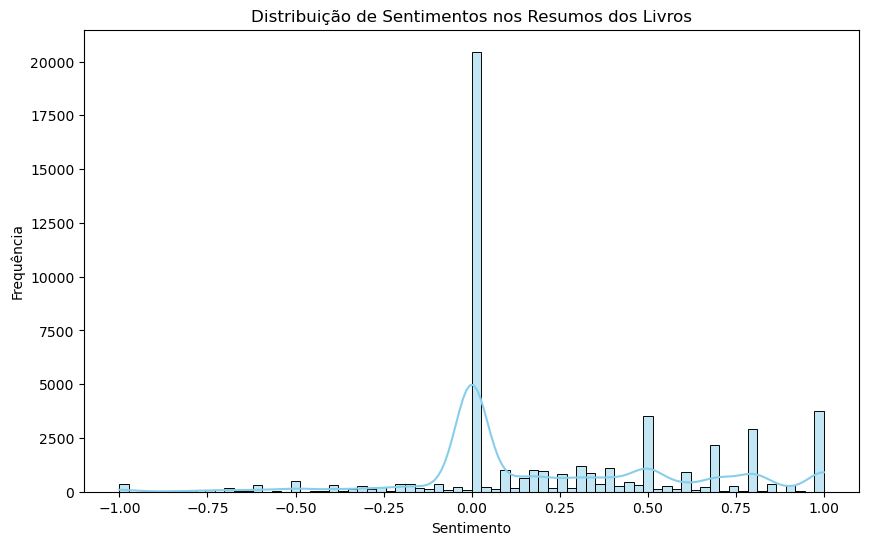

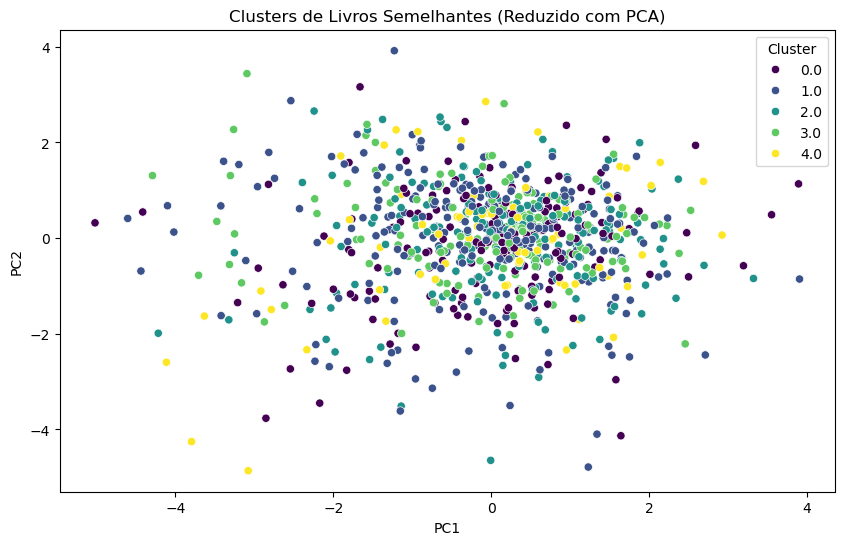

In [81]:
# Visualização 1: Frequência de Tópicos
if 'Dominant_Topic' in books_rating.columns:
    topic_counts = books_rating['Dominant_Topic'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
    plt.title("Frequência de Tópicos Identificados")
    plt.xlabel("Tópicos")
    plt.ylabel("Número de Livros")
    plt.show()

# Visualização 2: Distribuição de Sentimentos
if 'summary_sentiment' in books_rating.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(books_rating['summary_sentiment'], kde=True, color='skyblue')
    plt.title("Distribuição de Sentimentos nos Resumos dos Livros")
    plt.xlabel("Sentimento")
    plt.ylabel("Frequência")
    plt.show()

# Visualização 3: Clusters de Livros Semelhantes (PCA)
if 'Cluster' in books_rating.columns:
    # Reduzindo a dimensionalidade com PCA para visualização
    pca = PCA(n_components=2)
    book_embeddings_2d = pca.fit_transform(book_embeddings)

    # Criando um DataFrame para visualização
    cluster_df = pd.DataFrame(book_embeddings_2d, columns=['PC1', 'PC2'])
    cluster_df['Cluster'] = books_rating['Cluster']

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=cluster_df, palette="viridis", legend="full")
    plt.title("Clusters de Livros Semelhantes (Reduzido com PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.show();
